# Import supporting package

In [1]:
import xarray as xr
import numpy as np

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

import matplotlib.pyplot as plt

from DataContainer.ReadData import read_hdf5_file
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import NewFitModel
from ToolFunction.ToolFunction import *

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()

## Start a client for parallel computing

In [2]:
from dask.distributed import Client
client = Client(n_workers=6, threads_per_worker=10, processes=True, memory_limit='10GB')
client

C:\Users\data\AppData\Roaming\Python\Python39\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59281 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:59282' processes=6 threads=60, memory=55.88 GiB>

## Set global path for experiment

In [3]:
groupList = [
    "images/MOT_3D_Camera/in_situ_absorption",
    "images/ODT_1_Axis_Camera/in_situ_absorption",
    "images/ODT_2_Axis_Camera/in_situ_absorption",
]

dskey = {
    "images/MOT_3D_Camera/in_situ_absorption": "camera_1",
    "images/ODT_1_Axis_Camera/in_situ_absorption": "camera_2",
    "images/ODT_2_Axis_Camera/in_situ_absorption": "camera_3",
}


In [4]:
img_dir = '//DyLabNAS/Data/'
SequenceName = "Repetition_scan" + "/"
folderPath = img_dir + SequenceName + '2023/' + get_date()

# An example for one experimental run

## Load the data

In [ ]:
shotNum = "0065"
filePath = folderPath + "/" + shotNum + "/*.h5"
filePath = "//DyLabNAS/Data/Evaporative_Cooling/2023/05/12/0065/*.h5"

dataSetDict = {
    dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i])
    for i in [0] # range(len(groupList))
}

dataSet = dataSetDict["camera_1"]
dataSet = swap_xy(dataSet)

scanAxis = get_scanAxis(dataSet)

dataSet = auto_rechunk(dataSet)

dataSet = imageAnalyser.get_absorption_images(dataSet)

dataSet

## Calculate an plot OD images

In [ ]:
imageAnalyser.center = (959, 280)
imageAnalyser.span = (150, 200)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()

dataSet_cropOD.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])
plt.show()

## Do a 2D two-peak gaussian fit to the OD images

### Do the fit

In [ ]:
fitAnalyser = FitAnalyser("Gaussian-2D", fitDim=2)

params = fitAnalyser.guess(dataSet_cropOD, dask="parallelized")
fitResult = fitAnalyser.fit(dataSet_cropOD, params).load()

In [ ]:
fitCurve = fitAnalyser.eval(fitResult, x=np.arange(150), y=np.arange(200), dask="parallelized").load()

fitCurve.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])

### Get the result of the fit

In [ ]:
fitAnalyser.get_fit_value(fitResult)

In [ ]:
fitAnalyser.get_fit_std(fitResult)

In [ ]:
fitAnalyser.get_fit_full_result(fitResult)

## Get the Ncount

### Calculate the mean and standard deviation

In [ ]:
Ncount = imageAnalyser.get_Ncount(dataSet_cropOD)

Ncount.load()
Ncount_mean = calculate_mean(Ncount)
Ncount_std = calculate_std(Ncount)
Ncount_mean.plot.errorbar(yerr=Ncount_std)
plt.show()

###  Do a 1D fit

In [ ]:
def gaussian(x, amplitude=1.0, center=0.0, sigma=1.0):
    """Return a 1-dimensional Gaussian function.

    gaussian(x, amplitude, center, sigma) =
        (amplitude/(s2pi*sigma)) * exp(-(1.0*x-center)**2 / (2*sigma**2))

    """
    return ((amplitude/(max(1e-10, np.sqrt(2*np.pi)*sigma)))
            * np.exp(-(1.0*x-center)**2 / max(1e-10, (2*sigma**2))))

fitModel = NewFitModel(gaussian)

fitModel.make_params()

In [ ]:
fitAnalyser = FitAnalyser(fitModel, fitDim=1)

params = fitAnalyser.guess(Ncount_mean, x="sin_mod_freq", dask="parallelized")
fitResult = fitAnalyser.fit(Ncount_mean, params, x="sin_mod_freq").load()

plot_x = np.linspace(Ncount_mean["sin_mod_freq"].min(), Ncount_mean["sin_mod_freq"].max(), 100)

fitCurve = fitAnalyser.eval(fitResult, x=plot_x, dask="parallelized").load()

fig = plt.figure()
ax = fig.gca()

Ncount_mean.plot.errorbar(ax=ax, yerr=Ncount_std)
fitCurve.plot.errorbar(ax=ax, fmt='--g')

plt.show()

In [ ]:
fitCurve = fitCurve.rename(dict(x='final_amp'))
plot_dataSe = xr.combine_nested([Ncount_mean, fitCurve], ['plot'])

fig = plt.figure()
ax = fig.gca()
plot_dataSe.sel(plot=[0, 1]).plot.errorbar(ax=ax, hue='plot', x='final_amp', fmt=['ob', '-g'])
plt.show()


# Select data and remove bad shot

In [ ]:
plot_dataSe.where( (Ncount_mean[scanAxis[0]]<2e-4) & (Ncount_mean[scanAxis[0]]>1e-4) )

In [5]:
img_dir = '//DyLabNAS/Data/'
SequenceName = "Evaporative_Cooling" + "/"
folderPath = img_dir + SequenceName + '2023/05/17'

In [6]:
groupList = [
    "images/MOT_3D_Camera/in_situ_absorption",
    "images/ODT_1_Axis_Camera/in_situ_absorption",
    "images/ODT_2_Axis_Camera/in_situ_absorption",
]

dskey = {
    "images/MOT_3D_Camera/in_situ_absorption": "camera_0",
    "images/ODT_1_Axis_Camera/in_situ_absorption": "camera_1",
    "images/ODT_2_Axis_Camera/in_situ_absorption": "camera_2",
}

In [8]:
dataSet

<xarray.Dataset>
Dimensions:       (carrier_freq: 30, runs: 2, x: 1200, y: 1920)
Coordinates:
  * carrier_freq  (carrier_freq) float64 4.21 4.212 4.214 ... 4.264 4.266 4.268
  * runs          (runs) float64 0.0 1.0
Dimensions without coordinates: x, y
Data variables:
    atoms         (carrier_freq, runs, x, y) float64 dask.array<chunksize=(3, 2, 1200, 1920), meta=np.ndarray>
    background    (carrier_freq, runs, x, y) float64 dask.array<chunksize=(3, 2, 1200, 1920), meta=np.ndarray>
    dark          (carrier_freq, runs, x, y) float64 dask.array<chunksize=(3, 2, 1200, 1920), meta=np.ndarray>
    shotNum       (carrier_freq, runs) float64 dask.array<chunksize=(30, 2), meta=np.ndarray>
    OD            (carrier_freq, runs, x, y) float64 dask.array<chunksize=(3, 2, 1200, 1920), meta=np.ndarray>
Attributes: (12/120)
    TOF_free:                          0.01
    abs_img_freq:                      110.858
    absorption_imaging_flag:           True
    backup_data:                       True
    blink_off_time:                    0.001
    blink_on_time:                     0.001
    ...                                ...
    z_offset:                          0.189
    z_offset_img:                      0.189
    carrier_freq:                      [4.21  4.212 4.214 4.216 4.218 4.22  4...
    runs:                              [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...
    scanAxis:                          ['carrier_freq' 'runs']
    scanAxisLength:                    [58. 58.]

The detected scaning axes and values are: 

{'carrier_freq': array([4.21 , 4.212, 4.214, 4.216, 4.218, 4.22 , 4.222, 4.224, 4.226,
       4.228, 4.23 , 4.232, 4.234, 4.236, 4.238, 4.24 , 4.242, 4.244,
       4.246, 4.248, 4.25 , 4.252, 4.254, 4.256, 4.258, 4.26 , 4.262,
       4.264, 4.266, 4.268]), 'runs': array([0., 1.])}


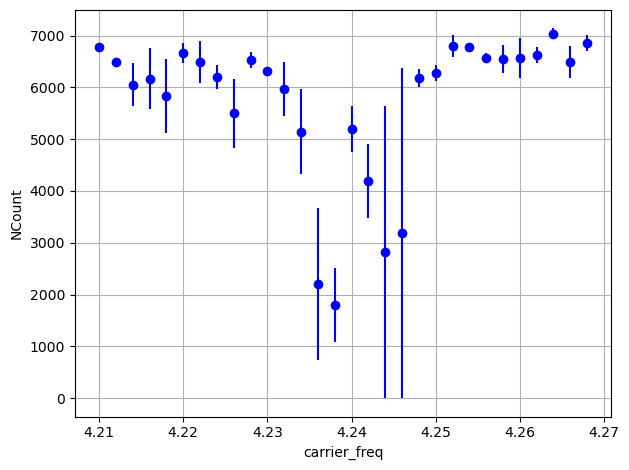

In [7]:
shotNum = "0023"
filePath = folderPath + "/" + shotNum + "/*.h5"

dataSetDict = {
    dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i])
    for i in [0]
}

dataSet = dataSetDict["camera_0"]

print_scanAxis(dataSet)

scanAxis = get_scanAxis(dataSet)

dataSet = auto_rechunk(dataSet)

dataSet = imageAnalyser.get_absorption_images(dataSet)

imageAnalyser.center = (280, 959)
imageAnalyser.span = (350, 350)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()

Ncount = imageAnalyser.get_Ncount(dataSet_cropOD)
Ncount_mean = Ncount.mean(dim='runs')
Ncount_std = Ncount.std(dim='runs')

fig = plt.figure()
ax = fig.gca()
Ncount_mean.plot.errorbar(ax=ax, yerr = Ncount_std, fmt='ob')

plt.ylabel('NCount')
plt.tight_layout()
#plt.ylim([0, 800])
plt.grid(visible=1)
plt.show()

In [105]:
def sinc_func(x, amplitude=1.0, center=0.0, sigma=1.0, offset=0.0):
    x = np.where(x==center, 1e-15, x)
    return amplitude * ( np.sin(np.pi*(x-center)*sigma) / (np.pi*( (x-center) )* max(sigma, 1e-15) ) ) + offset

fitModel = NewFitModel(sinc_func)

fitModel.make_params()

Parameters([('amplitude', <Parameter 'amplitude', value=1.0, bounds=[-inf:inf]>), ('center', <Parameter 'center', value=0.0, bounds=[-inf:inf]>), ('sigma', <Parameter 'sigma', value=1.0, bounds=[-inf:inf]>), ('offset', <Parameter 'offset', value=0.0, bounds=[-inf:inf]>)])

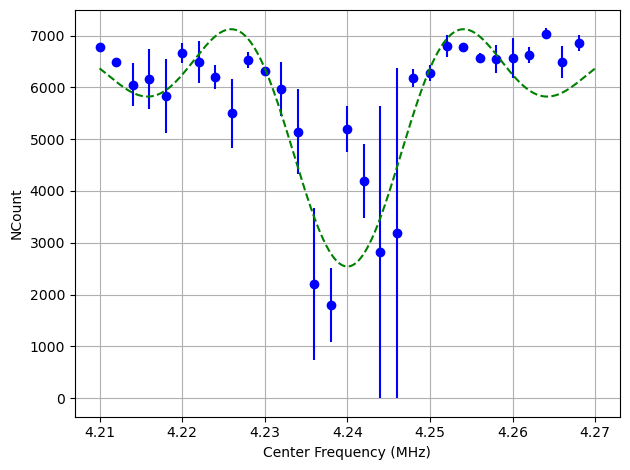

In [111]:
fitAnalyser = FitAnalyser(fitModel, fitDim=1)
# params = fitAnalyser.guess(Ncount_mean_1, x=scanAxis[0], guess_kwargs=dict(negative=True), dask="parallelized")
params = fitAnalyser.fitModel.make_params()
params.add(name="amplitude", value=  -5000, max=np.inf, min=-np.inf, vary=True)
params.add(name="center", value=  4.24, max=np.inf, min=-np.inf, vary=True)
params.add(name="sigma", value=  100, max=np.inf, min=  0, vary=True)
params.add(name="offset", value=  7000, max=np.inf, min=-np.inf, vary=True)

fitResult = fitAnalyser.fit(Ncount_mean, params, x=scanAxis[0]).load()
freqdata = np.linspace(4.21, 4.27, 500)
fitCurve = fitAnalyser.eval(fitResult, x=freqdata, dask="parallelized").load()
fitCurve = fitCurve.assign_coords({'x':np.array(freqdata)})

fig = plt.figure()
ax = fig.gca()

Ncount_mean.plot.errorbar(ax=ax, yerr = Ncount_std, fmt='ob')
fitCurve.plot.errorbar(ax=ax, fmt='--g')
plt.xlabel('Center Frequency (MHz)')
plt.ylabel('NCount')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [114]:
fitResult.item()

In [87]:
import lmfit

def sinc_func(x, amplitude=1.0, center=0.0, sigma=1.0, offset=0.0):
    x = np.where(x==center, 1e-5, x)
    return amplitude * ( np.sin(np.pi*(x-center)*max(sigma, 1e-5)) / (np.pi*( (x-center) )* max(sigma, 1e-5) ) ) + offset

def _fit_1D(data, params, x):
    
    print(x)
    print(data)
    
    res = fitModel.fit(data=data, x=x, params=params, nan_policy='omit')
    
    print(111)
    
    # print(res.items())
    
    return 1

def fit(dataArray, paramsArray, x=None, y=None, input_core_dims=None, dask='parallelized', vectorize=True, keep_attrs=True, daskKwargs=None, **kwargs):
    
    kwargs.update(
        {
            "dask": dask,
            "vectorize": vectorize,
            "input_core_dims": input_core_dims,
            'keep_attrs': keep_attrs,
        }
    )
    
    fitModel = NewFitModel(sinc_func)

    if not daskKwargs is None:
        kwargs.update({"dask_gufunc_kwargs": daskKwargs})
    
    if isinstance(paramsArray, type(fitModel.make_params())):

        if input_core_dims is None:
            kwargs.update(
                {
                    "input_core_dims": [['x']],
                }
            )

        if x is None:
            if 'x' in dataArray.dims:
                x = dataArray['x'].to_numpy()
        else:
            if isinstance(x, str):
                if input_core_dims is None:
                    kwargs.update(
                        {
                            "input_core_dims": [[x]],
                        }
                    )
                x = dataArray[x].to_numpy()

        return xr.apply_ufunc(_fit_1D, dataArray, kwargs={'params':paramsArray,'x':x},
                                output_dtypes=[type(lmfit.model.ModelResult(fitModel, fitModel.make_params()))], 
                                **kwargs)


In [96]:
params = fitAnalyser.fitModel.make_params()
params.add(name="amplitude", value=  -6000, max=np.inf, min=-np.inf, vary=True)
params.add(name="center", value=  4.24, max=np.inf, min=-np.inf, vary=True)
params.add(name="sigma", value=  1, max=np.inf, min=  0, vary=True)
params.add(name="offset", value=  6000, max=np.inf, min=-np.inf, vary=True)

In [97]:
fitResult = fit(Ncount_mean, params, x=scanAxis[0]).load()

[4.21  4.212 4.214 4.216 4.218 4.22  4.222 4.224 4.226 4.228 4.23  4.232
 4.234 4.236 4.238 4.24  4.242 4.244 4.246 4.248 4.25  4.252 4.254 4.256
 4.258 4.26  4.262 4.264 4.266 4.268]
[6769.67956065 6481.29550119 6053.12583223 6167.32988037 5832.95142324
 6666.80232023 6495.09820957 6194.86783408 5496.9058868  6528.28343547
 6320.13082993 5967.89140337 5146.70221327 2198.13874681 1791.42699994
 5195.29511407 4194.74291752 2821.57312863 3186.06344255 6177.81491664
 6281.72290362 6793.60854331 6780.77347622 6566.97442088 6551.53646254
 6566.30218537 6630.50401754 7033.66568469 6485.86052695 6861.09580952]
111


In [95]:
def sinc_func(x, amplitude=1.0, center=0.0, sigma=1.0, offset=0.0):
    x = np.where(x==center, 1e-5, x)
    return amplitude * ( np.sin(np.pi*(x-center)*max(sigma, 1e-5)) / (np.pi*( (x-center) )* max(sigma, 1e-5) ) ) + offset

fitModel = NewFitModel(sinc_func)

fitModel.make_params()

data = Ncount_mean.to_numpy()
x = Ncount_mean.carrier_freq.to_numpy()

fitModel.fit(data=data, x=x, params=params, nan_policy='omit')

In [78]:
np.where(x==0, 1, 2)

SyntaxError: positional argument follows keyword argument (864697295.py, line 1)